# Prueba técnica de Orange
by Héctor Ramírez

<hr>

In this notebook, we study a simple dataset and construct both linear and logistic regression predictive models using several algorithms.

<hr>




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score, roc_curve, confusion_matrix, classification_report
warnings.filterwarnings('ignore')

<hr>
We start by loading the data and explore its info and statistics. We see it comes with four features (two numerical columns, one of string type and one of boolean type). No null entries exist.
<hr>

In [2]:
data = pd.read_csv('salary.csv')
print(data.head())
print('\n')
print(data.info())
print('\n')
print(data.describe())

   Salary  Experience Education  Management
0   13876           1  Bachelor        True
1   11608           1       PhD       False
2   18701           1       PhD        True
3   11283           1    Master       False
4   11767           1       PhD       False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
Salary        46 non-null int64
Experience    46 non-null int64
Education     46 non-null object
Management    46 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 1.2+ KB
None


             Salary  Experience
count     46.000000   46.000000
mean   17270.195652    7.500000
std     4716.631513    5.171503
min    10535.000000    1.000000
25%    13320.750000    3.000000
50%    16436.000000    6.000000
75%    20719.750000   11.000000
max    27837.000000   20.000000


## Exploratory Data Analysis

<hr>
We then perform an EDA of the columns. We are mainly interested in how Education, Experience and whether the sample belongs to a Management position affects the Salary. But also, how the Management variable is affected by the rest.
<hr>

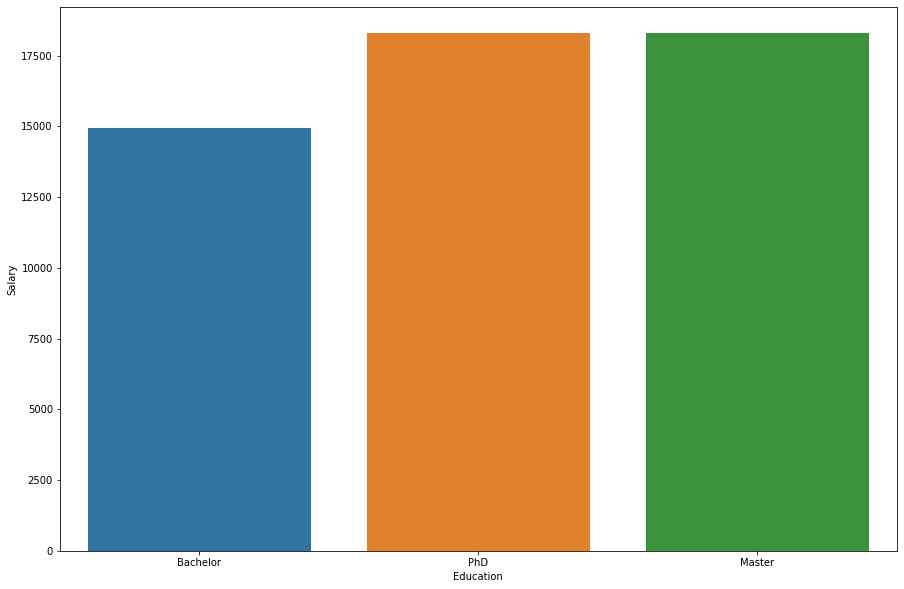

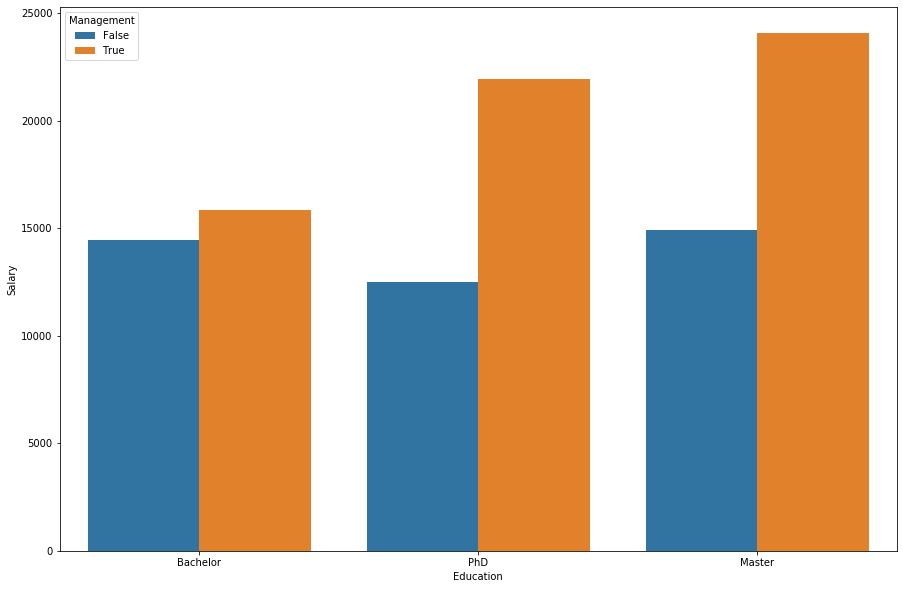

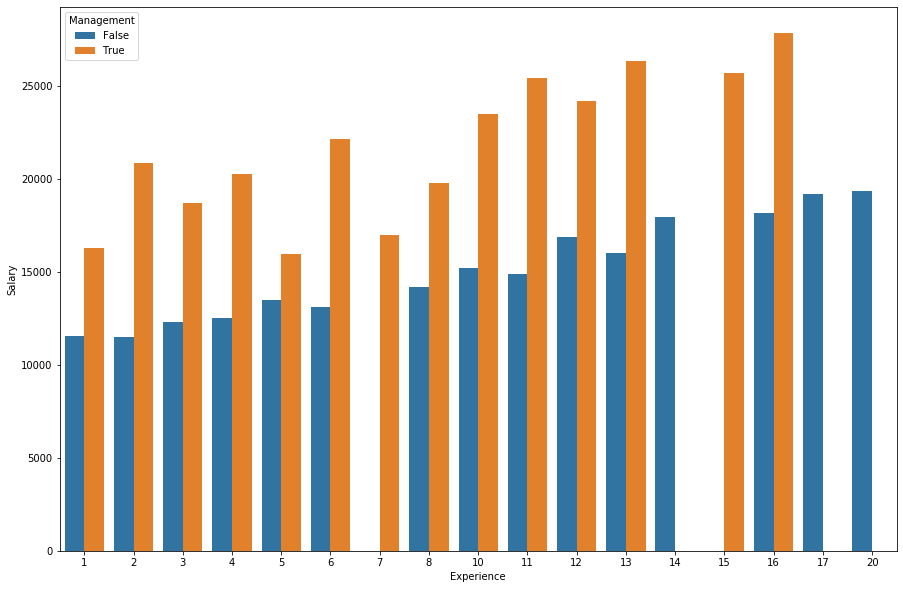

In [3]:
plt.figure(figsize=(15,10))
sns.barplot(x='Education', y='Salary', data=data, ci=None)
plt.figure(figsize=(15,10))
sns.barplot(x='Education', y='Salary', hue='Management', data=data, ci=None)
plt.figure(figsize=(15,10))
sns.barplot(x='Experience', y='Salary', hue='Management', data=data, ci=None)

<hr>
We clearly see that there is a correlation in Salary and whether a person has undergraduate or graduate study levels. However the correlation does not hold when we separate the cases with respect to the Management variable as clearly the PhD salaries decrease. On the other hand, the correlation clearly holds with respect to Experience, independently of the Management variable.
<br><br>
To see it more clearly, we plot a correlation matrix after categorically splitting the Education variable.
<hr>

                      Salary  Experience  Management  Education_Bachelor  \
Salary              1.000000    0.538886    0.729525           -0.330174   
Experience          0.538886    1.000000   -0.051441            0.083130   
Management          0.729525   -0.051441    1.000000           -0.103593   
Education_Bachelor -0.330174    0.083130   -0.103593            1.000000   
Education_Master    0.182727    0.142423   -0.112297           -0.554861   
Education_PhD       0.137589   -0.240695    0.228662           -0.415149   

                    Education_Master  Education_PhD  
Salary                      0.182727       0.137589  
Experience                  0.142423      -0.240695  
Management                 -0.112297       0.228662  
Education_Bachelor         -0.554861      -0.415149  
Education_Master            1.000000      -0.526514  
Education_PhD              -0.526514       1.000000  


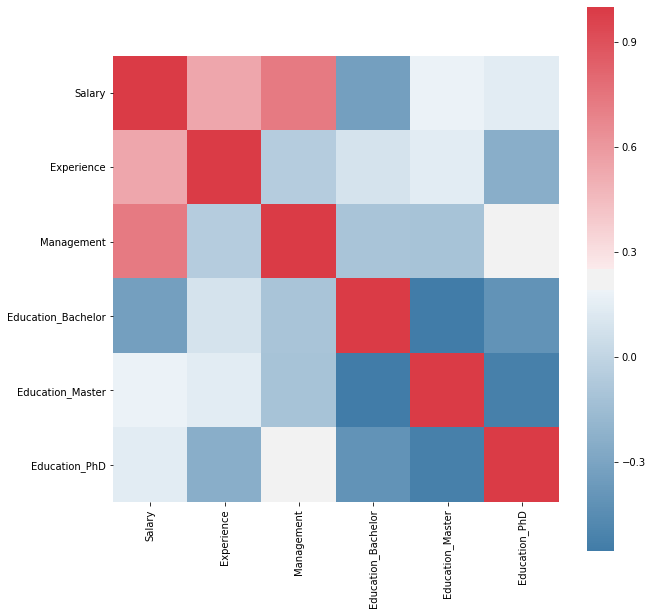

In [4]:
data = pd.get_dummies(data)  # Transform categorical data ('Education')

# Correlation matrix
corr = pd.DataFrame(data).corr()
print(corr)

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240, 10, as_cmap=True),
            square=True, ax=ax)

<hr>
We again notice that the salary is more influenced by the Experience and Management variables than the Education one. However, a Master's appears to have more effect than PhD (as we found before) and than Bachelor's.
<br><br>
On the other hand, the Management variable is by far more affected by the Salary, followed by a PhD education level.
<hr>

We now construct predictive models for the Salary variable.

## Linear Regression

First, we try a simple linear regressor using <code>LinearRegression()</code> from <code>sklearn.linear_model</code>. As test metrics, we will apply the <b>root mean squared error</b> and the <b>coefficient of determination</b> $R^2$ (score).

In [5]:
seed = 123
X = data.drop(['Salary'], axis=1)  # Features
y = data['Salary']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_error = mse(y_test, y_pred)**(1/2)
lr_accuracy = r2_score(y_test, y_pred)

print('Test set RMSE of linear regressor: {:.2f}'.format(lr_error))
print('Test set score of linear regressor: {:.4f}'.format(lr_accuracy))

Test set RMSE of linear regressor: 1127.19
Test set score of linear regressor: 0.9434


<hr>
The simple Linear Regressor performs fairly well, with a score of 94.34% when applied on the test set.
<hr>

#### Random Forest

However, let's try a slightly more complex regressor using Random Forests. Here, instead of simply suggesting a model, we perform a parameter grid search using <code>GridSearchCV</code> from <code>sklearn.model_selection</code> by varying the number of stimators, the maximum tree depth and the minimum of leaf samples, this while cross-validating the model.

Best hyperparameters:
 {'max_depth': 7, 'min_samples_leaf': 0.01, 'n_estimators': 10}
Test set RMSE of complex random forest: 1065.94


Test set score of complex random forest: 0.9494


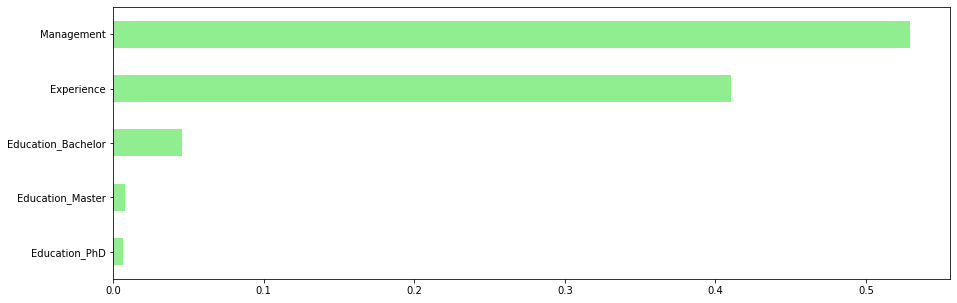

In [6]:
rf_g = RandomForestRegressor(random_state=seed)

params_rf = {'n_estimators': [5, 10, 20], 'max_depth': [5, 7, 9], 'min_samples_leaf': np.arange(0.01, 0.1, 0.02)}

grid_rf = GridSearchCV(estimator=rf_g, param_grid=params_rf, cv=3, scoring='neg_mean_squared_error',
                       verbose=0, n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)

grid_rf_error = mse(y_test, y_pred)**(1/2)
grid_rf_accuracy = r2_score(y_test, y_pred)

print('Test set RMSE of complex random forest: {:.2f}'.format(grid_rf_error))
print('\n')
print('Test set score of complex random forest: {:.4f}'.format(grid_rf_accuracy))

importances_rf = pd.Series(best_model.feature_importances_, index=X.columns)
sorted_importances_rf = importances_rf.sort_values()
plt.figure(figsize=(15,5))
sorted_importances_rf.plot(kind='barh', color='lightgreen')

<hr>
As we can see, our RandomForest regressor slightly outperforms the simple linear regresor, with an score of 94.94% when applied on the test set. Furthermore, we took the most important features employed by the RandomForest regressor and showed them in a bar plot. We notice that Management is by far the most important feature, followed by Experience, as expected.
<hr>

## Logistic Regression

We now want to see how the Salary, Education and Experience affect whether a person has a Management position or not.
<br><br>
This is a classification problem. Therefore, we construct a logistic regression model and, accordingly, our test metrics will include the confussion matrix and the Receiver Operating Characteristic (ROC) curve (a plot of the true positive rate against the false positive rate).
<hr>

Confusion matrix:
[[4 3]
 [0 7]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.70      1.00      0.82         7

    accuracy                           0.79        14
   macro avg       0.85      0.79      0.78        14
weighted avg       0.85      0.79      0.78        14



Text(0.5, 1.0, 'Logistic Regression ROC Curve')

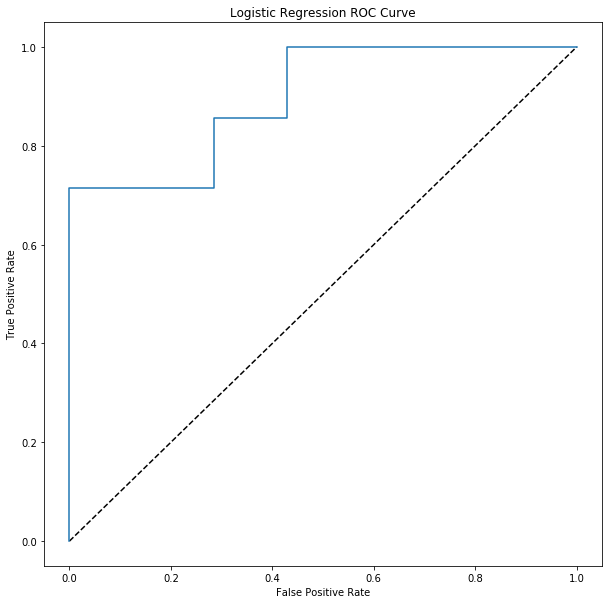

In [7]:
# Transform Boolean to categorical
data['Management'] = data['Management'].astype('category')
data['Management'] = data['Management'].cat.codes

X = data.drop(['Management'], axis=1)  # Features
y = data['Management']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

logreg_error = mse(y_test, y_pred)**(1/2)
logreg_accuracy = r2_score(y_test, y_pred)

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(10, 10))
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

We can see that for the small test set, the logistic regressor has an averaged precision of 85% (correct predictions) and a f-1 score of 79% (correct positive predictions).
<br><br>
As for the feature importances, by printing the feature coefficients generated by the model, we notice that the first entry (Salary) has the greatest influence onf Management, as expected.

In [8]:
print(logreg.coef_)

[[ 2.83979323e-04 -2.83785837e-01 -5.47715609e-01 -1.19037287e+00
  -2.70149006e-01]]
